### Deskripsi Singkat Dataset:

tulis deskripsi singkat dataset yang Anda gunakan

---

### Dataset yang diambil dari repositori:

COVID Face Mask Detection Dataset – sumber : https://www.kaggle.com/datasets/prithwirajmitra/covid-face-mask-detection-dataset

### Hasil kerja

In [2]:
import cv2
import math, time, random, datetime
import os
import numpy as np
from matplotlib import pyplot as plt
# import splitfolders
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

Path untuk folder data

In [88]:
TRAIN_PATH  = './kaggle/Train' #Mengandung 90% dari dataset
TEST_PATH  = './kaggle/Test' # Mengandung 10% dari dataset

IMG_SIZE = 224

Memberi Label pada gambar serta membagi dataset menjadi training dan validation.

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32
)

Found 906 files belonging to 2 classes.
Using 725 files for training.
Found 906 files belonging to 2 classes.
Using 181 files for validation.


In [72]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)

(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(21, 224, 224, 3)


Membuat Model menggunakan MobileNetV2 sebagai Base model.

In [53]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # Include false agar dapat menggantikan top layer dari model dengan layer khusus kita nanti
                                               weights='imagenet')

9406464/9406464 [==============================] - 8s 1us/step


Jika telah inisialisasi model, maka memasukin training model.

Sebelum model dilatih, base_model trainable dimatikan dulu. Kita ingin mematikan layer-layer bawah dari model agar tidak menggantika bobot yang membuatnya mengenal wajah.

Layer convolution pada lapisan pertama base_model akan berfungsi sebagai feature extractor.

In [55]:
base_model.trainable = False

Kita akan menggunakan Global Average Pooling 2D layer untuk mengubah vector yang didapati dari base_model menjadi 1280 vector.

Setelah mendapatkan vector tersebut membuat klasifikasi dilakukan menggunakan Dense Layer.

In [64]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)
stacked_layers = [global_average_layer, prediction_layer]

Layer yang terbuat kemudian akan ditaruh diatas base model.

In [65]:
model = tf.keras.Sequential([base_model] + stacked_layers)

Menetapkan base_learning_rate dan membuat membuat model.

In [66]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
            

### Melatih dan membuat evaluasi
Jika tanpa training hasil yang diberikan adalah:

In [78]:
validation_steps = 6
initial_epochs = 100

loss0,accuracy0 = model.evaluate(val_ds, steps = validation_steps)

6/6 [==============================] - 3s 437ms/step - loss: 0.6879 - accuracy: 0.5635


Dapa dilihat, model hanya 0.5635 akurat dalam mendeteksi wajah bermasker. Hal ini tidak bagus karena, jika model menebak maka hasilnya 0.5. Jadi meskipun memiliki bobot dari ImageNet dan architecure MobileNetV2 (transfer learning), model hanya  bisa menentukan wajah bermasker sedikit lebih baik dari penebakan.

Melatih model (layer teratas)

In [79]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/100
23/23 [==============================] - 17s 617ms/step - loss: 0.6736 - accuracy: 0.5531 - val_loss: 0.6381 - val_accuracy: 0.6243
Epoch 2/100
23/23 [==============================] - 14s 593ms/step - loss: 0.6392 - accuracy: 0.5848 - val_loss: 0.6117 - val_accuracy: 0.6575
Epoch 3/100
23/23 [==============================] - 14s 580ms/step - loss: 0.6139 - accuracy: 0.6152 - val_loss: 0.5949 - val_accuracy: 0.6961
Epoch 4/100
23/23 [==============================] - 14s 587ms/step - loss: 0.5921 - accuracy: 0.6469 - val_loss: 0.5760 - val_accuracy: 0.7182
Epoch 5/100
23/23 [==============================] - 14s 590ms/step - loss: 0.5710 - accuracy: 0.6552 - val_loss: 0.5639 - val_accuracy: 0.7127
Epoch 6/100
23/23 [==============================] - 14s 607ms/step - loss: 0.5538 - accuracy: 0.6897 - val_loss: 0.5473 - val_accuracy: 0.7238
Epoch 7/100
23/23 [==============================] - 14s 596ms/step - loss: 0.5361 - accuracy: 0.7048 - val_loss: 0.5334 - val_accuracy:

History dari Training dan Fitting

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


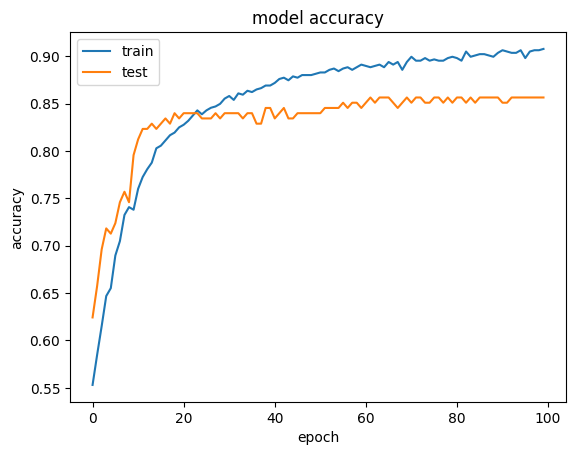

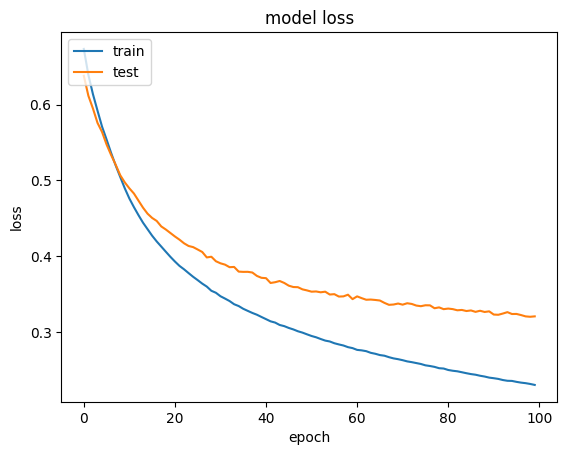

In [80]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Found 100 files belonging to 2 classes.


In [90]:
for image_batch, labels_batch in test_ds:
    print(image_batch.shape)

(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(4, 224, 224, 3)


1

Evaluasi dengan Testing

In [96]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_PATH,
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32
)
testing_steps = 4


loss0,accuracy0 = model.evaluate(test_ds, steps = testing_steps)

Found 100 files belonging to 2 classes.
4/4 [==============================] - 2s 300ms/step - loss: 0.2540 - accuracy: 0.9400


In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [85]:
len(base_model.layers)

154

Fine-tuning model saat epoch = 24